# Artificial Neural Networks and Deep Learning

---

## Homework 1


### ⏳ Load the Data

In [8]:
import numpy as np

data = np.load('training_set.npz')
X = data['images']
y = data['labels'] # Load the training data here
print(y.shape)

(13759, 1)


In [9]:
# elimina i duplicati
X, indices = np.unique(X, return_index=True, axis=0)
y = y[indices]
print(X.shape)
print(y.shape)

(11953, 96, 96, 3)
(11953, 1)


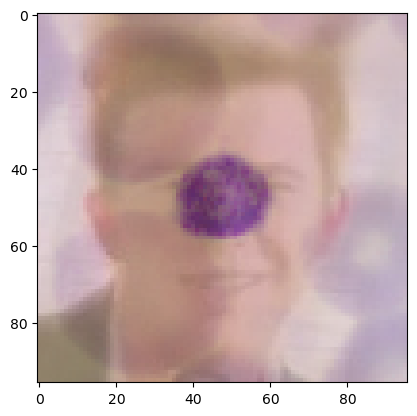

In [10]:
import matplotlib.pyplot as plt

plt.imshow(X[1008])

In [11]:
# intruso_idx è l'indice dell'immagine da eliminare
intruso_idx = 1008

# Elimina l'immagine dall'array X
X = np.delete(X, intruso_idx, axis=0)

# Elimina anche la corrispondente etichetta dall'array y
y = np.delete(y, intruso_idx, axis=0)

print(f"Nuova shape di X: {X.shape}")
print(f"Nuova shape di y: {y.shape}")

Nuova shape di X: (11952, 96, 96, 3)
Nuova shape di y: (11952, 1)


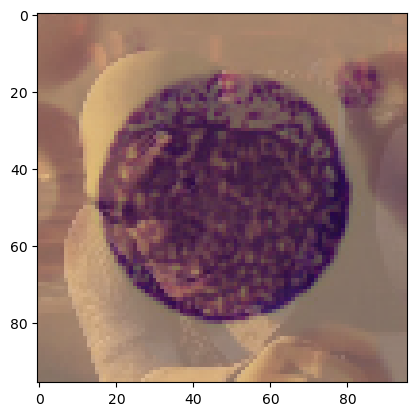

In [12]:
plt.imshow(X[58])

In [13]:
# intruso_idx è l'indice dell'immagine da eliminare
intruso_idx = 58

# Elimina l'immagine dall'array X
X = np.delete(X, intruso_idx, axis=0)

# Elimina anche la corrispondente etichetta dall'array y
y = np.delete(y, intruso_idx, axis=0)

print(f"Nuova shape di X: {X.shape}")
print(f"Nuova shape di y: {y.shape}")

Nuova shape di X: (11951, 96, 96, 3)
Nuova shape di y: (11951, 1)


In [14]:
!pip install -r requirements.txt

In [15]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Carica il modello preaddestrato
model = load_model('weights_1.keras')

In [28]:
for layer in model.layers:
    print(f"Layer: {layer.name} - {type(layer).__name__}")
    if hasattr(layer, 'layers'):  # Controlla i livelli nidificati
        for nested_layer in layer.layers:
            print(f"  Nested Layer: {nested_layer.name} - {type(nested_layer).__name__}")

Layer: input_layer - InputLayer
Layer: preprocessing - Sequential
  Nested Layer: random_flip_1 - RandomFlip
  Nested Layer: random_rotation_1 - RandomRotation
  Nested Layer: random_zoom_1 - RandomZoom
Layer: MobileNetV3Large - Functional
  Nested Layer: input_layer - InputLayer
  Nested Layer: rescaling - Rescaling
  Nested Layer: conv - Conv2D
  Nested Layer: conv_bn - BatchNormalization
  Nested Layer: activation - Activation
  Nested Layer: expanded_conv_depthwise - DepthwiseConv2D
  Nested Layer: expanded_conv_depthwise_bn - BatchNormalization
  Nested Layer: re_lu - ReLU
  Nested Layer: expanded_conv_project - Conv2D
  Nested Layer: expanded_conv_project_bn - BatchNormalization
  Nested Layer: expanded_conv_add - Add
  Nested Layer: expanded_conv_1_expand - Conv2D
  Nested Layer: expanded_conv_1_expand_bn - BatchNormalization
  Nested Layer: re_lu_1 - ReLU
  Nested Layer: expanded_conv_1_depthwise_pad - ZeroPadding2D
  Nested Layer: expanded_conv_1_depthwise - DepthwiseConv2D
  

In [18]:
import numpy as np
import scipy.ndimage
import tensorflow.keras as tfk

def compute_CAM(model, img, nested_model_name="MobileNetV3Large", final_conv_layer_name="conv_1"):
    """
    Calcola la Class Activation Map (CAM) per un'immagine e un modello con struttura nidificata.
    """
    # Espandi le dimensioni dell'immagine per adattarle al modello
    img = np.expand_dims(img, axis=0)
    
    # Predici la classe vincente
    predictions = model.predict(img, verbose=0)
    label_index = np.argmax(predictions)

    # Ottieni i pesi del livello dense (fully connected)
    dense_layer = model.get_layer('dense_3')  # Livello completamente connesso prima dell'output finale
    class_weights = dense_layer.get_weights()[0]  # Pesi del livello dense
    class_weights_winner = class_weights[:, label_index]  # Pesi della classe vincente

    # Accedi al modello nidificato
    nested_model = model.get_layer(nested_model_name)
    
    # Estrai il livello convoluzionale finale dal modello nidificato
    final_conv_layer = tfk.Model(
        nested_model.input,
        nested_model.get_layer(final_conv_layer_name).output
    )
    
    # Calcola l'output convoluzionale
    conv_outputs = final_conv_layer(img)
    conv_outputs = np.squeeze(conv_outputs)

    # Calcola la CAM come somma pesata dei canali convoluzionali
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[:2])
    for i, w in enumerate(class_weights_winner):
        cam += w * conv_outputs[:, :, i]

    # Normalizza la CAM
    cam = np.maximum(cam, 0)  # Applica ReLU
    cam = cam / (cam.max() + 1e-8)  # Normalizza tra 0 e 1

    # Upsample della CAM alla dimensione dell'immagine originale
    cam_resized = scipy.ndimage.zoom(cam, (img.shape[1] / cam.shape[0], img.shape[2] / cam.shape[1]), order=1)

    return cam_resized, label_index, predictions

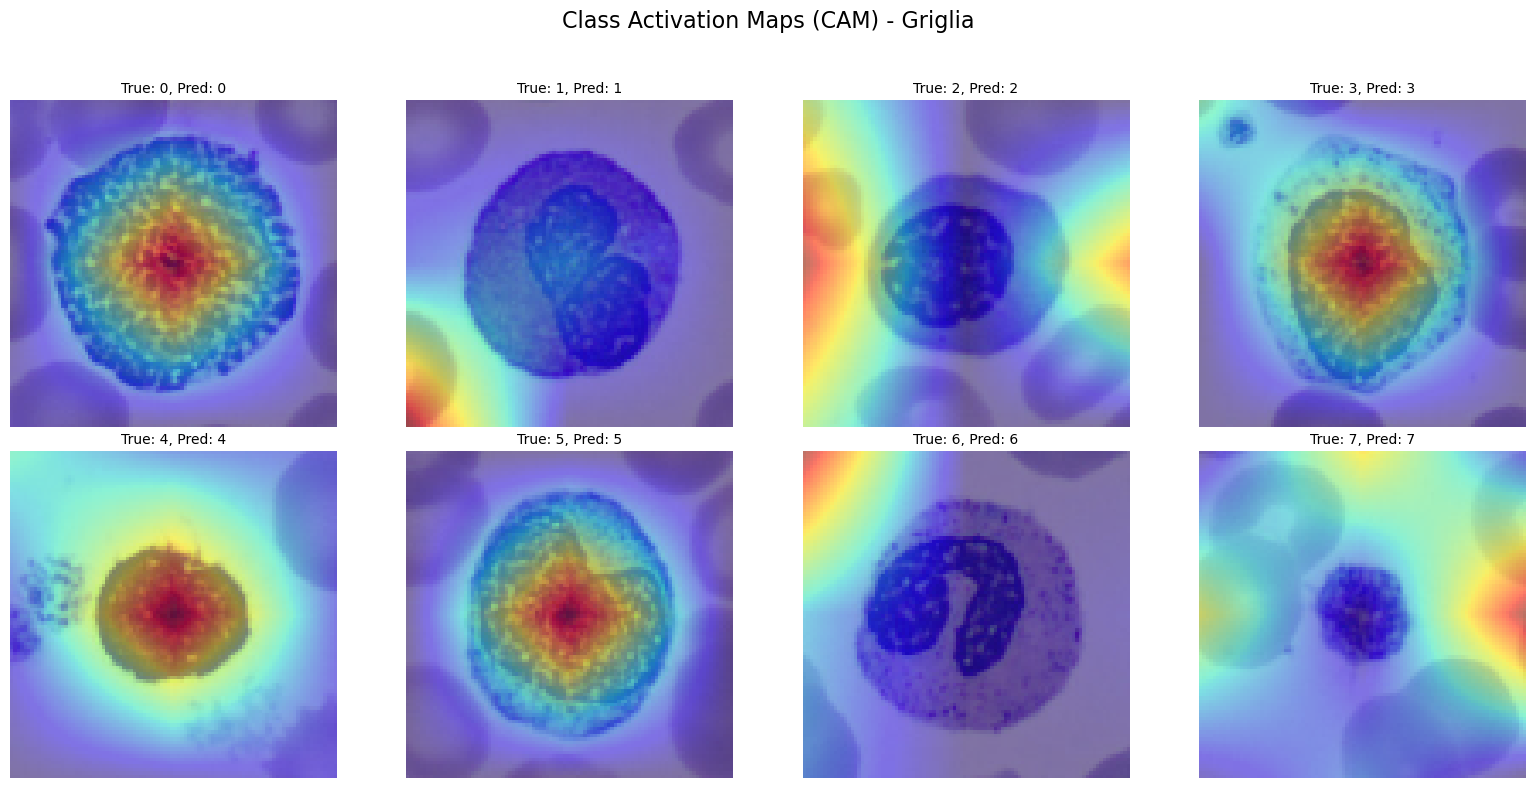

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_CAMs_in_grid(model, X, y, num_classes=8, nested_model_name="MobileNetV3Large", final_conv_layer_name="conv_1"):
    """
    Visualizza una singola immagine con una griglia di 8 immagini, 1 per classe, disposte in 2 righe e 4 colonne.
    """
    # Crea una griglia
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Griglia con 2 righe e 4 colonne
    fig.suptitle('Class Activation Maps (CAM) - Griglia', fontsize=16)
    
    # Per ogni classe
    for class_id in range(num_classes):
        # Trova un indice di immagine per la classe corrente
        img_index = np.random.choice(np.where(y.flatten() == class_id)[0])
        img = X[img_index]  # Estrai l'immagine
        true_label = y[img_index][0]  # Classe reale
        
        # Calcola la CAM
        cam, predicted_label, predictions = compute_CAM(
            model,
            img,
            nested_model_name=nested_model_name,
            final_conv_layer_name=final_conv_layer_name
        )
        
        # Trova l'asse corrente nella griglia
        ax = axes[class_id // 4, class_id % 4]  # Riga e colonna in base all'indice di classe
        
        # Visualizza l'immagine con CAM sovrapposta
        ax.imshow(img / 255.0)  # Normalizza l'immagine per la visualizzazione
        ax.imshow(cam, cmap='jet', alpha=0.5)  # Sovrappone la CAM
        ax.axis('off')  # Rimuove gli assi
        
        # Mostra la classe reale e predetta
        ax.set_title(f'True: {true_label}, Pred: {predicted_label}', fontsize=10)
    
    # Aggiusta la spaziatura
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('CAM_griglia_7.png')  # Nome del file immagine salvato
    plt.show()

# Esegui la funzione
plot_CAMs_in_grid(
    model=model,
    X=X,
    y=y,
    num_classes=8,
    nested_model_name="MobileNetV3Large",
    final_conv_layer_name="conv_1"
)